In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 13%|███████▊                                                      | 7502/60000 [00:00<00:00, 75010.06it/s]

 25%|███████████████▎                                             | 15004/60000 [00:00<00:00, 73810.56it/s]

 38%|███████████████████████                                      | 22734/60000 [00:00<00:00, 75388.34it/s]

 51%|██████████████████████████████▉                              | 30452/60000 [00:00<00:00, 76089.40it/s]

 63%|██████████████████████████████████████▋                      | 38077/60000 [00:00<00:00, 76146.36it/s]

 76%|██████████████████████████████████████████████▍              | 45693/60000 [00:00<00:00, 72293.77it/s]

 88%|█████████████████████████████████████████████████████▊       | 52957/60000 [00:00<00:00, 70230.84it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73159.31it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████                     | 6628/10000 [00:00<00:00, 66275.48it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 68129.61it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 84spf8e2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/368 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/368 [00:00<02:47,  2.19it/s]

  3%|█▉                                                                   | 10/368 [00:00<00:15, 23.07it/s]

  5%|███▌                                                                 | 19/368 [00:00<00:08, 39.99it/s]

  8%|█████▎                                                               | 28/368 [00:00<00:06, 53.20it/s]

 10%|██████▉                                                              | 37/368 [00:00<00:05, 63.17it/s]

 12%|████████▋                                                            | 46/368 [00:00<00:04, 70.63it/s]

 15%|██████████▎                                                          | 55/368 [00:01<00:04, 76.03it/s]

 17%|████████████                                                         | 64/368 [00:01<00:03, 79.76it/s]

 20%|█████████████▉                                                       | 74/368 [00:01<00:03, 83.01it/s]

 23%|███████████████▌                                                     | 83/368 [00:01<00:03, 84.89it/s]

 25%|█████████████████▎                                                   | 92/368 [00:01<00:03, 86.25it/s]

 27%|██████████████████▋                                                 | 101/368 [00:01<00:03, 87.26it/s]

 30%|████████████████████▎                                               | 110/368 [00:01<00:02, 87.93it/s]

 32%|█████████████████████▉                                              | 119/368 [00:01<00:02, 88.38it/s]

 35%|███████████████████████▋                                            | 128/368 [00:01<00:02, 88.67it/s]

 37%|█████████████████████████▎                                          | 137/368 [00:01<00:02, 88.97it/s]

 40%|██████████████████████████▉                                         | 146/368 [00:02<00:02, 89.19it/s]

 42%|████████████████████████████▋                                       | 155/368 [00:02<00:02, 89.35it/s]

 45%|██████████████████████████████▍                                     | 165/368 [00:02<00:02, 89.60it/s]

 47%|████████████████████████████████▏                                   | 174/368 [00:02<00:02, 89.61it/s]

 50%|█████████████████████████████████▊                                  | 183/368 [00:02<00:02, 89.65it/s]

 52%|███████████████████████████████████▍                                | 192/368 [00:02<00:01, 89.06it/s]

 55%|█████████████████████████████████████▏                              | 201/368 [00:02<00:01, 89.16it/s]

 57%|██████████████████████████████████████▊                             | 210/368 [00:02<00:01, 89.39it/s]

 60%|████████████████████████████████████████▍                           | 219/368 [00:02<00:01, 89.54it/s]

 62%|██████████████████████████████████████████▏                         | 228/368 [00:02<00:01, 89.58it/s]

 64%|███████████████████████████████████████████▊                        | 237/368 [00:03<00:01, 89.65it/s]

 67%|█████████████████████████████████████████████▍                      | 246/368 [00:03<00:01, 89.69it/s]

 69%|███████████████████████████████████████████████                     | 255/368 [00:03<00:01, 89.67it/s]

 72%|████████████████████████████████████████████████▊                   | 264/368 [00:03<00:01, 89.72it/s]

 74%|██████████████████████████████████████████████████▍                 | 273/368 [00:03<00:01, 89.76it/s]

 77%|████████████████████████████████████████████████████                | 282/368 [00:03<00:00, 89.75it/s]

 79%|█████████████████████████████████████████████████████▊              | 291/368 [00:03<00:00, 89.76it/s]

 82%|███████████████████████████████████████████████████████▍            | 300/368 [00:03<00:00, 89.68it/s]

 84%|█████████████████████████████████████████████████████████           | 309/368 [00:03<00:00, 89.26it/s]

 86%|██████████████████████████████████████████████████████████▊         | 318/368 [00:03<00:00, 89.37it/s]

 89%|████████████████████████████████████████████████████████████▍       | 327/368 [00:04<00:00, 89.53it/s]

 91%|██████████████████████████████████████████████████████████████      | 336/368 [00:04<00:00, 89.61it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 346/368 [00:04<00:00, 89.77it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 356/368 [00:04<00:00, 89.90it/s]

 99%|███████████████████████████████████████████████████████████████████▋| 366/368 [00:04<00:00, 90.18it/s]

100%|████████████████████████████████████████████████████████████████████| 368/368 [00:04<00:00, 79.99it/s]

train - OK


  0%|                                                                               | 0/92 [00:00<?, ?it/s]

  5%|███▊                                                                   | 5/92 [00:00<00:01, 45.47it/s]

 15%|██████████▋                                                           | 14/92 [00:00<00:01, 69.74it/s]

 25%|█████████████████▌                                                    | 23/92 [00:00<00:00, 78.36it/s]

 35%|████████████████████████▎                                             | 32/92 [00:00<00:00, 82.46it/s]

 45%|███████████████████████████████▏                                      | 41/92 [00:00<00:00, 84.85it/s]

 54%|██████████████████████████████████████                                | 50/92 [00:00<00:00, 86.30it/s]

 64%|████████████████████████████████████████████▉                         | 59/92 [00:00<00:00, 86.06it/s]

 74%|███████████████████████████████████████████████████▋                  | 68/92 [00:00<00:00, 87.06it/s]

 84%|██████████████████████████████████████████████████████████▌           | 77/92 [00:00<00:00, 87.65it/s]

 95%|██████████████████████████████████████████████████████████████████▏   | 87/92 [00:01<00:00, 88.53it/s]

100%|██████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 80.63it/s]

val - OK


  0%|                                                                               | 0/76 [00:00<?, ?it/s]

  5%|███▋                                                                   | 4/76 [00:00<00:01, 38.94it/s]

 17%|███████████▉                                                          | 13/76 [00:00<00:00, 67.96it/s]

 29%|████████████████████▎                                                 | 22/76 [00:00<00:00, 77.59it/s]

 41%|████████████████████████████▌                                         | 31/76 [00:00<00:00, 81.98it/s]

 53%|████████████████████████████████████▊                                 | 40/76 [00:00<00:00, 84.40it/s]

 64%|█████████████████████████████████████████████▏                        | 49/76 [00:00<00:00, 85.69it/s]

 76%|█████████████████████████████████████████████████████▍                | 58/76 [00:00<00:00, 86.66it/s]

 88%|█████████████████████████████████████████████████████████████▋        | 67/76 [00:00<00:00, 87.32it/s]

100%|██████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 80.07it/s]

100%|██████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 78.60it/s]

test InD - OK


  0%|                                                                              | 0/559 [00:00<?, ?it/s]

  1%|▌                                                                     | 4/559 [00:00<00:14, 38.54it/s]

  2%|█▌                                                                   | 13/559 [00:00<00:08, 66.33it/s]

  4%|██▋                                                                  | 22/559 [00:00<00:07, 75.79it/s]

  6%|███▊                                                                 | 31/559 [00:00<00:06, 80.38it/s]

  7%|████▉                                                                | 40/559 [00:00<00:06, 82.87it/s]

  9%|██████                                                               | 49/559 [00:00<00:06, 84.63it/s]

 10%|███████▏                                                             | 58/559 [00:00<00:05, 85.58it/s]

 12%|████████▎                                                            | 67/559 [00:00<00:05, 86.33it/s]

 14%|█████████▍                                                           | 76/559 [00:00<00:05, 86.82it/s]

 15%|██████████▍                                                          | 85/559 [00:01<00:05, 87.23it/s]

 17%|███████████▌                                                         | 94/559 [00:01<00:05, 87.46it/s]

 18%|████████████▌                                                       | 103/559 [00:01<00:05, 87.56it/s]

 20%|█████████████▌                                                      | 112/559 [00:01<00:05, 87.65it/s]

 22%|██████████████▋                                                     | 121/559 [00:01<00:04, 87.74it/s]

 23%|███████████████▊                                                    | 130/559 [00:01<00:04, 87.80it/s]

 25%|████████████████▉                                                   | 139/559 [00:01<00:04, 87.78it/s]

 26%|██████████████████                                                  | 148/559 [00:01<00:04, 87.88it/s]

 28%|███████████████████                                                 | 157/559 [00:01<00:04, 87.85it/s]

 30%|████████████████████▏                                               | 166/559 [00:01<00:04, 87.85it/s]

 31%|█████████████████████▎                                              | 175/559 [00:02<00:04, 87.89it/s]

 33%|██████████████████████▍                                             | 184/559 [00:02<00:04, 88.00it/s]

 35%|███████████████████████▍                                            | 193/559 [00:02<00:04, 88.02it/s]

 36%|████████████████████████▌                                           | 202/559 [00:02<00:04, 87.97it/s]

 38%|█████████████████████████▋                                          | 211/559 [00:02<00:03, 87.90it/s]

 39%|██████████████████████████▊                                         | 220/559 [00:02<00:03, 88.22it/s]

 41%|███████████████████████████▊                                        | 229/559 [00:02<00:03, 88.21it/s]

 43%|████████████████████████████▉                                       | 238/559 [00:02<00:03, 88.39it/s]

 44%|██████████████████████████████                                      | 247/559 [00:02<00:03, 88.46it/s]

 46%|███████████████████████████████▏                                    | 256/559 [00:02<00:03, 88.49it/s]

 47%|████████████████████████████████▏                                   | 265/559 [00:03<00:03, 88.59it/s]

 49%|█████████████████████████████████▎                                  | 274/559 [00:03<00:03, 88.57it/s]

 51%|██████████████████████████████████▍                                 | 283/559 [00:03<00:03, 88.49it/s]

 52%|███████████████████████████████████▌                                | 292/559 [00:03<00:03, 88.53it/s]

 54%|████████████████████████████████████▌                               | 301/559 [00:03<00:02, 88.71it/s]

 55%|█████████████████████████████████████▋                              | 310/559 [00:03<00:02, 88.80it/s]

 57%|██████████████████████████████████████▊                             | 319/559 [00:03<00:02, 88.83it/s]

 59%|███████████████████████████████████████▉                            | 328/559 [00:03<00:02, 88.82it/s]

 60%|████████████████████████████████████████▉                           | 337/559 [00:03<00:02, 88.78it/s]

 62%|██████████████████████████████████████████                          | 346/559 [00:03<00:02, 88.86it/s]

 64%|███████████████████████████████████████████▏                        | 355/559 [00:04<00:02, 88.76it/s]

 65%|████████████████████████████████████████████▎                       | 364/559 [00:04<00:02, 88.78it/s]

 67%|█████████████████████████████████████████████▎                      | 373/559 [00:04<00:02, 88.80it/s]

 68%|██████████████████████████████████████████████▍                     | 382/559 [00:04<00:01, 88.85it/s]

 70%|███████████████████████████████████████████████▌                    | 391/559 [00:04<00:01, 88.81it/s]

 72%|████████████████████████████████████████████████▋                   | 400/559 [00:04<00:01, 88.83it/s]

 73%|█████████████████████████████████████████████████▊                  | 409/559 [00:04<00:01, 88.72it/s]

 75%|██████████████████████████████████████████████████▊                 | 418/559 [00:04<00:01, 88.74it/s]

 76%|███████████████████████████████████████████████████▉                | 427/559 [00:04<00:01, 88.83it/s]

 78%|█████████████████████████████████████████████████████               | 436/559 [00:04<00:01, 88.86it/s]

 80%|██████████████████████████████████████████████████████▏             | 445/559 [00:05<00:01, 88.42it/s]

 81%|███████████████████████████████████████████████████████▏            | 454/559 [00:05<00:01, 88.38it/s]

 83%|████████████████████████████████████████████████████████▎           | 463/559 [00:05<00:01, 88.49it/s]

 84%|█████████████████████████████████████████████████████████▍          | 472/559 [00:05<00:00, 88.57it/s]

 86%|██████████████████████████████████████████████████████████▌         | 481/559 [00:05<00:00, 88.64it/s]

 88%|███████████████████████████████████████████████████████████▌        | 490/559 [00:05<00:00, 88.64it/s]

 89%|████████████████████████████████████████████████████████████▋       | 499/559 [00:05<00:00, 88.74it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 508/559 [00:05<00:00, 88.69it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 517/559 [00:05<00:00, 88.67it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 526/559 [00:06<00:00, 88.85it/s]

 96%|█████████████████████████████████████████████████████████████████   | 535/559 [00:06<00:00, 88.85it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 544/559 [00:06<00:00, 88.93it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 553/559 [00:06<00:00, 89.07it/s]

100%|████████████████████████████████████████████████████████████████████| 559/559 [00:06<00:00, 86.58it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:00, 91.72it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:00, 91.46it/s]

 30%|████████████████████▋                                                | 30/100 [00:00<00:00, 91.98it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 91.87it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:00<00:00, 91.36it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:00<00:00, 90.99it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:00<00:00, 90.73it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:00<00:00, 90.64it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:00<00:00, 90.56it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.54it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.90it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(23523, 1, 32, 32) (23523, 1, 32, 32) (23523, 256) (23523, 5) (23523,)
(5881, 1, 32, 32) (5881, 1, 32, 32) (5881, 256) (5881, 5) (5881,)
(4861, 1, 32, 32) (4861, 1, 32, 32) (4861, 256) (4861, 5) (4861,)
(35735, 1, 32, 32) (35735, 1, 32, 32) (35735, 256) (35735, 5) (35735,)
(6400, 1, 32, 32) (6400, 1, 32, 32) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


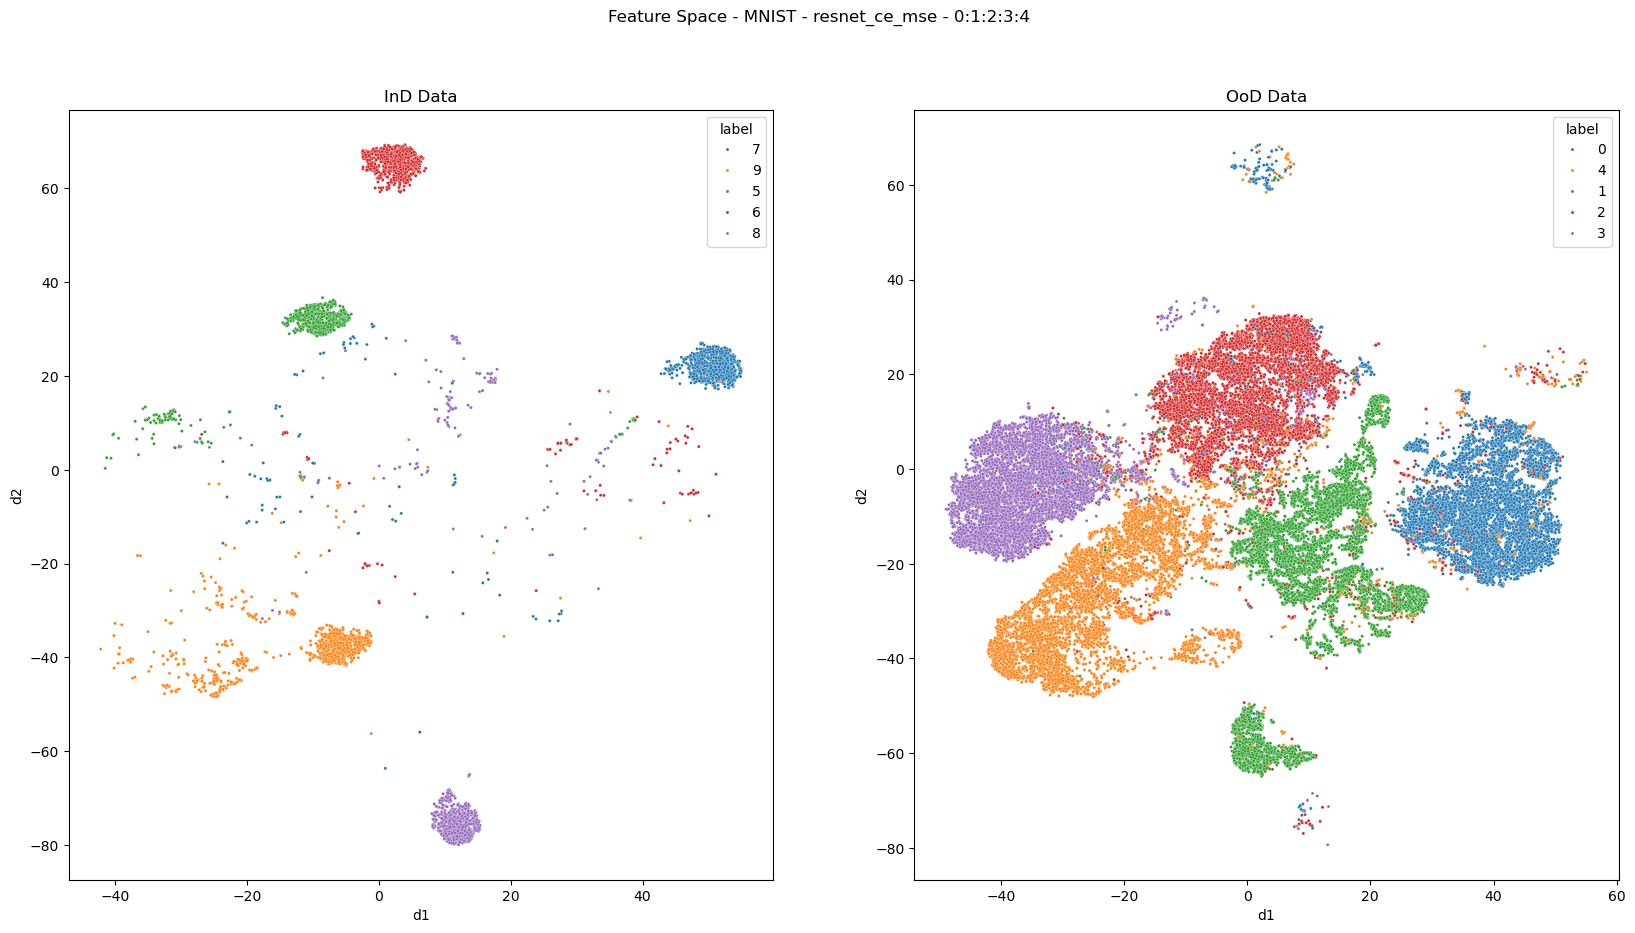

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

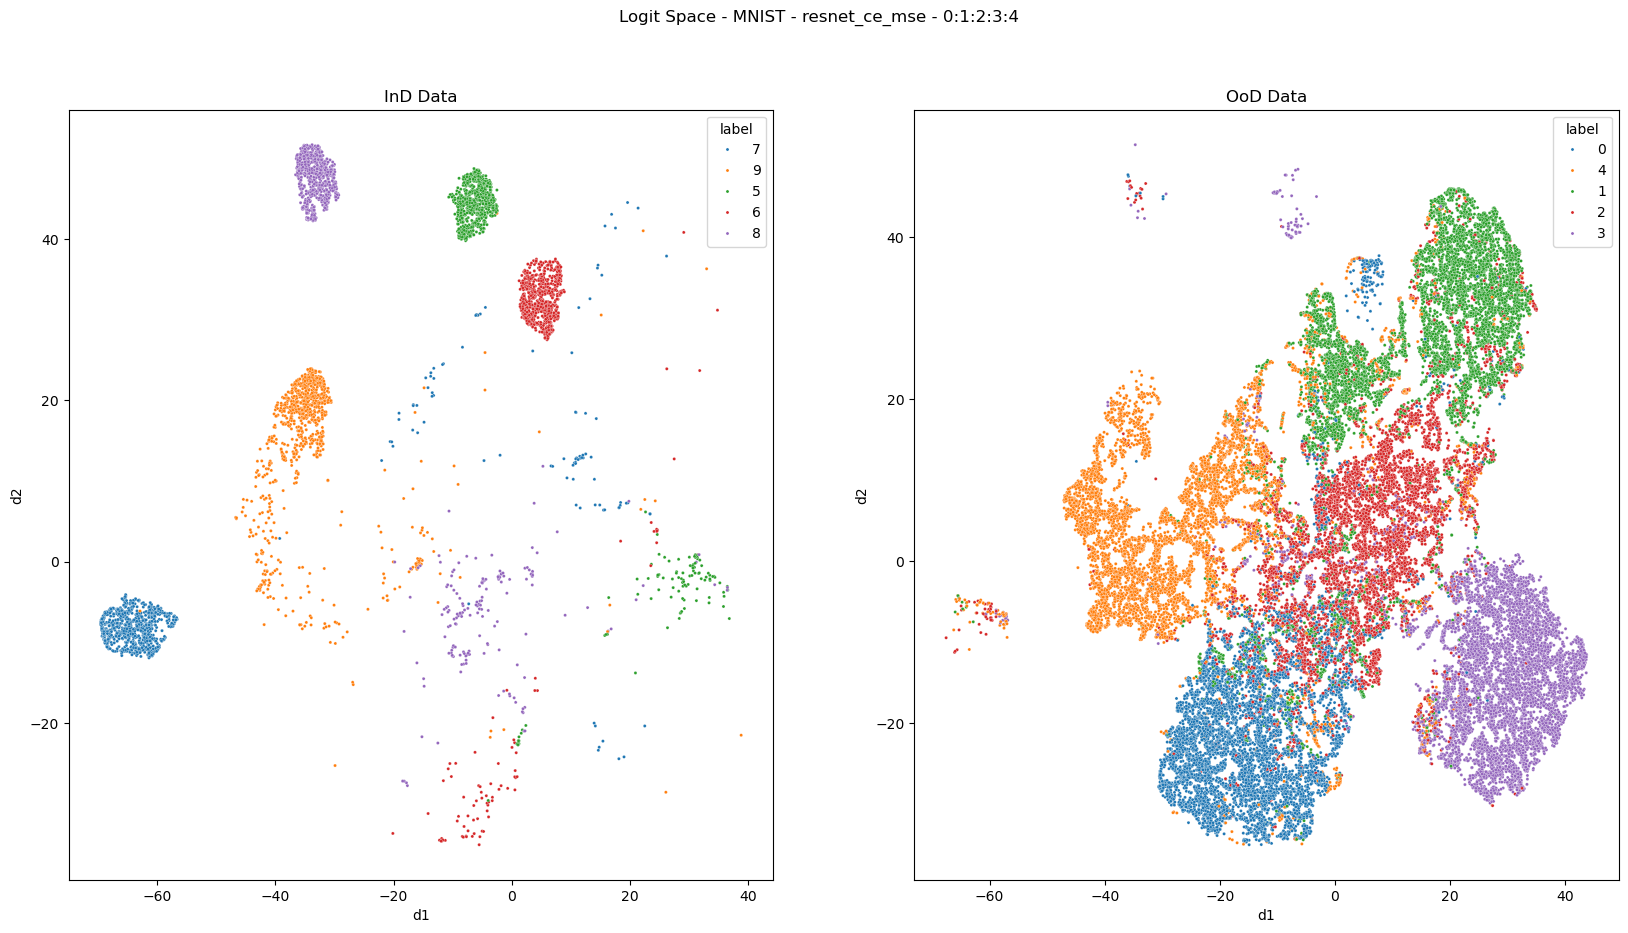

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.08s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.20s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

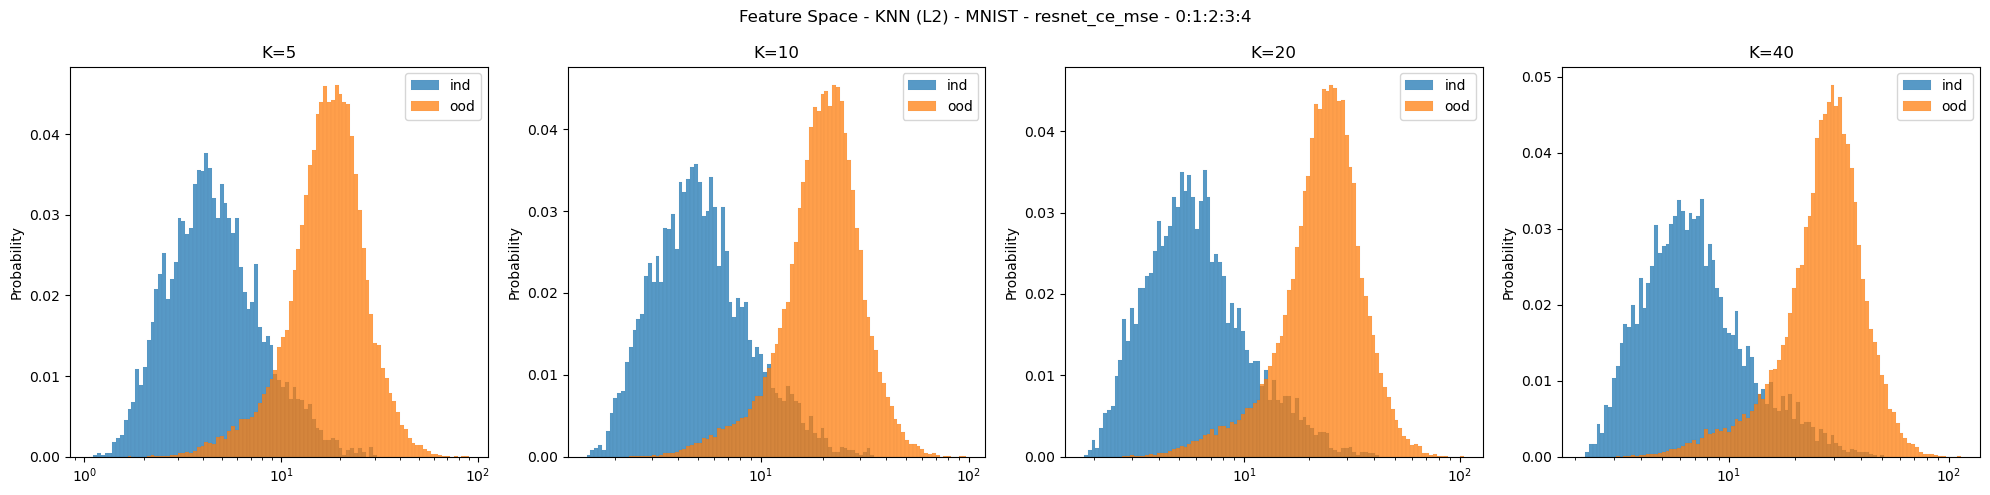

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.03s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.05s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

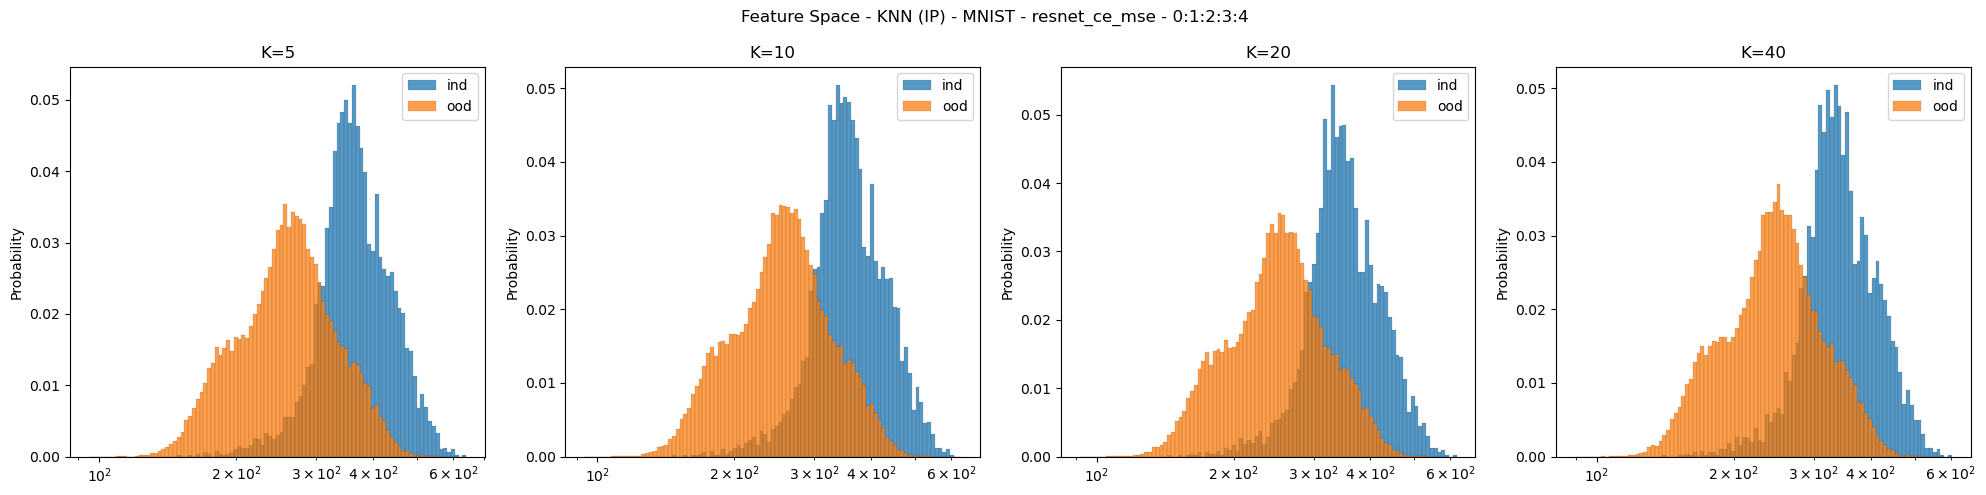

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.61it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.45it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.19it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]

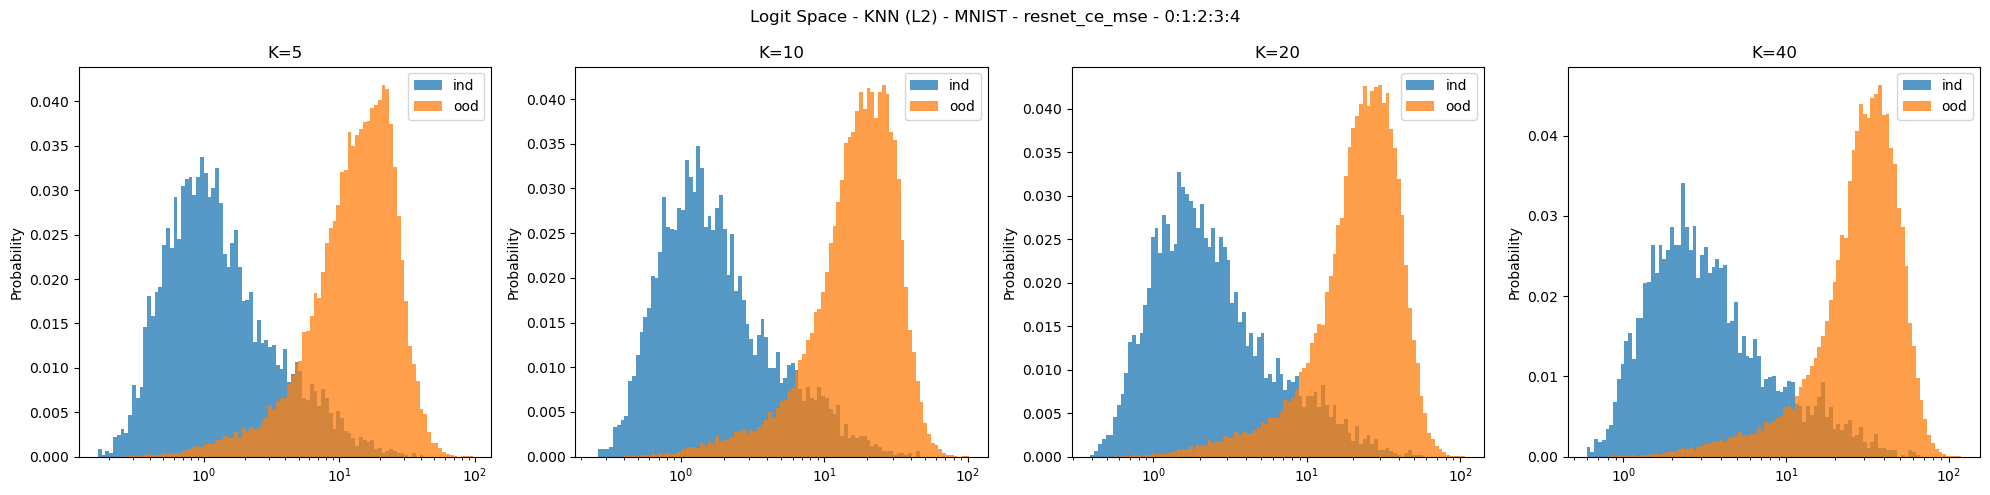

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.88it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:01,  1.93it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  1.99it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]

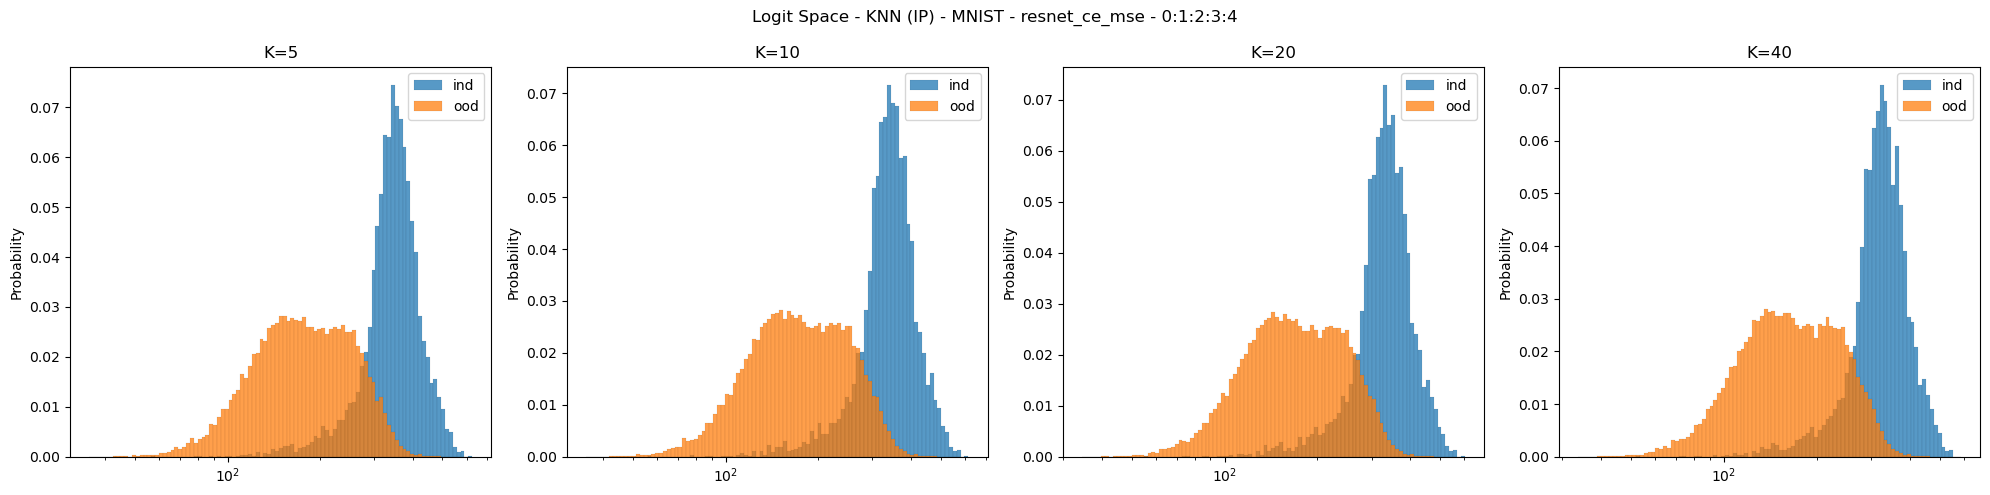

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

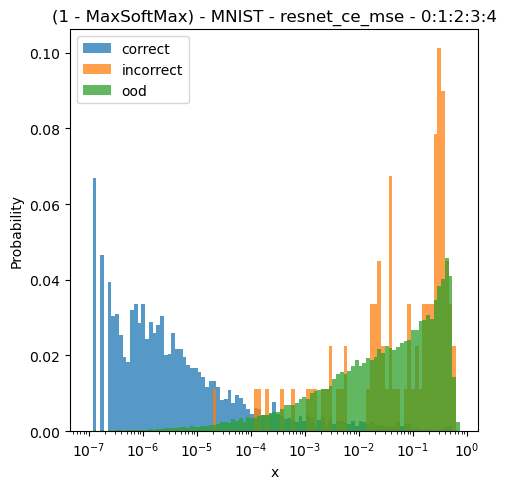

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

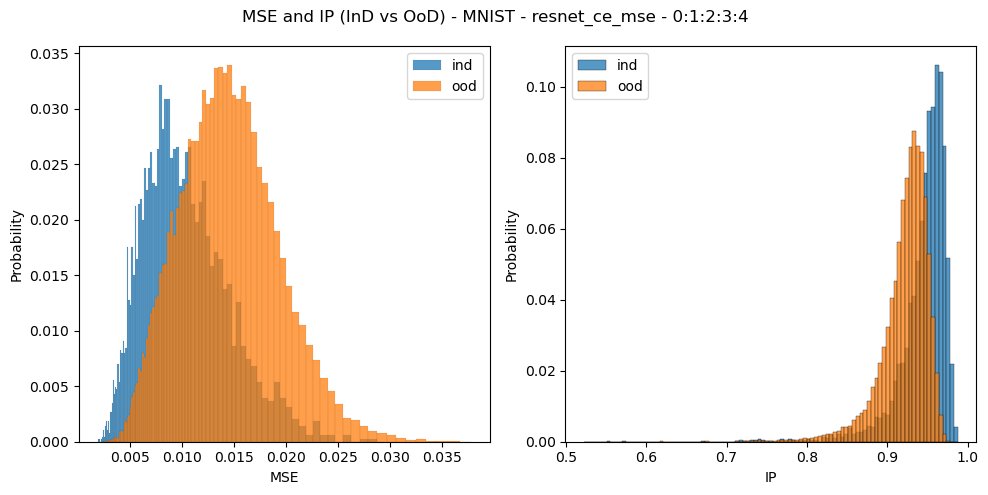

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()